<h1><strong>Vehicle Audio Classification (Machine Learning Approach)</strong></h1>

<strong>Lie Reubensto</strong> <br>
<strong>Speech & Audio Processing Project 3</strong> <br>
<strong>Run in Kaggle</strong>

Dataset Link: <br>
https://www.kaggle.com/datasets/brinkor/vehicle-type-sound-dataset

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tqdm import tqdm
import pywt
import scipy
import shutil
import soundfile as sf
import librosa
from IPython.display import Audio

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [2]:
# Load Dataset
df = pd.read_csv("/kaggle/input/vehicle-type-sound-dataset/vehicle_type_sound_dataset/labels.csv")

# Base path to prepend
base_path = "/kaggle/input/vehicle-type-sound-dataset/vehicle_type_sound_dataset/"

# Prepend the base path to the file_path column
df['file_path'] = df['file_path'].apply(lambda x: os.path.join(base_path, x))

# Display the updated DataFrame
df

,file_path,class
0,/kaggle/input/vehicle-type-sound-dataset/vehic...,1
1,/kaggle/input/vehicle-type-sound-dataset/vehic...,0
2,/kaggle/input/vehicle-type-sound-dataset/vehic...,0
3,/kaggle/input/vehicle-type-sound-dataset/vehic...,0
4,/kaggle/input/vehicle-type-sound-dataset/vehic...,1
...,...,...
1700,/kaggle/input/vehicle-type-sound-dataset/vehic...,0
1701,/kaggle/input/vehicle-type-sound-dataset/vehic...,1
1702,/kaggle/input/vehicle-type-sound-dataset/vehic...,1
1703,/kaggle/input/vehicle-type-sound-dataset/vehic...,0


In [3]:
# Check the rows of data each class has
print(df['class'].value_counts())

class
0    1212
1     467
2      26
Name: count, dtype: int64


In [4]:
# Check dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1705 entries, 0 to 1704
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  1705 non-null   object
 1   class      1705 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 26.8+ KB


In [5]:
# Check sample
sample = df['file_path'][0]
y, sr = librosa.load(sample)
print(f"Audio Data   : {y}")
print(f"Sampling Eate: {sr}")
Audio(data=y, rate=sr)

Audio Data   : [ 0.00069706  0.00154941  0.00132327 ... -0.0024666  -0.00218814
 -0.00137787]
Sampling Eate: 22050


In [6]:
# Assuming df is your DataFrame and the 'class' column is labeled with class numbers.
motorcycle = df[df['class'] == 2]

# Define the Kaggle working directory (for example)
kaggle_working_path = "/kaggle/working/augmented_data"

# Create the output directory if it doesn't exist
if not os.path.exists(kaggle_working_path):
    os.makedirs(kaggle_working_path)

In [7]:
# Augmentation of Motocycle Data
def augment_audio(y, sr, seed=SEED):
    # Set the random seed if provided, for reproducibility
    if seed is not None:
        np.random.seed(seed)
    
    augmented = []

    # Pitch Shifting
    n_steps = np.random.randint(-4, 5)  # Randomly choose a pitch shift value between -4 and 5 half-steps
    y_pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)  # Correct usage
    augmented.append(y_pitch)

    # Time Stretching
    rate = np.random.uniform(0.8, 1.2)  # Randomly choose a stretch rate between 0.8 and 1.2
    y_stretch = librosa.effects.time_stretch(y, rate=rate)
    augmented.append(y_stretch)

    # Add Noise
    noise = np.random.normal(0, 0.01, y.shape)  # Random noise
    y_noisy = y + noise
    augmented.append(y_noisy)

    # Change Volume
    volume_factor = np.random.uniform(0.5, 1.5)  # Random volume scaling factor
    y_louder = y * volume_factor
    augmented.append(y_louder)

    # Random Cropping
    crop_size = 22050  # Length of the crop (e.g., 1 second at 22050 Hz)
    if len(y) > crop_size:
        start = np.random.randint(0, len(y) - crop_size)
        y_crop = y[start:start + crop_size]
        augmented.append(y_crop)
    else:
        augmented.append(y)  # If audio is too short, don't crop

    # Random Reversal
    y_reverse = np.flip(y)
    augmented.append(y_reverse)

    # Random Speed Change (Without Stretching)
    speed_factor = np.random.uniform(0.8, 1.2)
    y_speed = librosa.effects.time_stretch(y, rate=speed_factor)
    augmented.append(y_speed)

    return augmented

In [8]:
# List to store the new rows (augmented audio samples)
augmented_rows = []

# Process the motorcycle data
for _, row in motorcycle.iterrows():
    file_path = row['file_path']
    
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)
    
    # Apply augmentations
    augmented_samples = augment_audio(y, sr, seed=SEED)
    
    # Save the augmented samples and update the file_path
    for idx, augmented_sample in enumerate(augmented_samples):
        new_file_name = f"motorcycle_aug_{_}_{idx}.wav"
        new_file_path = os.path.join(kaggle_working_path, new_file_name)
        
        # Save the augmented audio
        sf.write(new_file_path, augmented_sample, sr)
        
        # Add the new entry to the augmented rows
        augmented_rows.append({'file_path': new_file_path, 'class': 2})
        
# Convert the augmented data to a DataFrame
augmented_df = pd.DataFrame(augmented_rows)

# Append the augmented data to the original dataframe (optional)
df_augmented = pd.concat([df, augmented_df], ignore_index=True)

# Show the value counts of the augmented data
print("Value counts of the augmented data:")
print(df_augmented['class'].value_counts())

# Path to the augmented audio data
print(f"Augmented audio files are saved in: {kaggle_working_path}")

Value counts of the augmented data:
class
0    1212
1     467
2     208
Name: count, dtype: int64
Augmented audio files are saved in: /kaggle/working/augmented_data


In [9]:
# Undersample
small = df_augmented['class'].value_counts().min()

class_0 = df_augmented[df_augmented['class'] == 0].sample(n=small, random_state=SEED)
class_1 = df_augmented[df_augmented['class'] == 1].sample(n=small, random_state=SEED)
class_2 = df_augmented[df_augmented['class'] == 2]

In [10]:
# Combine the Undersampled Data and Shuffle It
df1 = pd.concat([class_0, class_1, class_2]).sample(frac=1, random_state=SEED).reset_index(drop=True)

# Check the new class distribution
print("New class distribution:")
print(df1['class'].value_counts())

New class distribution:
class
2    208
1    208
0    208
Name: count, dtype: int64


In [11]:
# Audio Feature Extraction
def extract_audio_features(df, audio_column, sr=22050, n_mfcc=13, n_fft=2048, hop_length=512):
    features_list = []

    for file_path in tqdm(df[audio_column], desc="Extracting Features"):
        try:
            # Load audio
            y, sr = librosa.load(file_path, sr=sr)

            # General features
            rms = np.mean(librosa.feature.rms(y=y))
            fundamental_freq = np.mean(librosa.yin(y=y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7')))

            # Spectral features
            spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length))
            spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length))
            spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length))
            spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=y))
            
            # Zero-crossing rate
            zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y))

            # MFCCs
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
            mfcc_mean = np.mean(mfcc, axis=1)
            
            # Harmonic-to-Noise Ratio
            harmonic = librosa.effects.harmonic(y=y)
            noise = y - harmonic
            hnr = np.mean(np.abs(harmonic) / (np.abs(noise) + 1e-10))
            
            # Wavelet entropy
            coeffs = pywt.wavedec(y, wavelet='db1', level=5)
            wavelet_entropy = -np.sum([np.sum(c**2) * np.log(np.sum(c**2) + 1e-10) for c in coeffs])

            # Statistical features
            skewness = scipy.stats.skew(y)
            kurtosis = scipy.stats.kurtosis(y)

            # Combine features
            feature_vector = np.hstack([
                rms, fundamental_freq, spectral_centroid, spectral_bandwidth, spectral_rolloff,
                spectral_flatness, zero_crossing_rate, mfcc_mean, hnr, wavelet_entropy, skewness, kurtosis
            ])
            features_list.append(feature_vector)

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            features_list.append([np.nan] * 13 + [np.nan] * n_mfcc)

    # Define feature columns
    feature_columns = [
        "RMS", "Fundamental_Freq", "Spectral_Centroid", "Spectral_Bandwidth",
        "Spectral_Rolloff", "Spectral_Flatness", "Zero_Crossing_Rate", "HNR",
        "Wavelet_Entropy", "Skewness", "Kurtosis"
    ] + [f"MFCC_{i+1}" for i in range(n_mfcc)]

    features_df = pd.DataFrame(features_list, columns=feature_columns)
    return pd.concat([df.reset_index(drop=True), features_df], axis=1)

In [12]:
# Extract Audio Features
df2 = extract_audio_features(df1, 'file_path')

Extracting Features: 100%|██████████| 624/624 [03:59<00:00,  2.60it/s]


In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   file_path           624 non-null    object 
 1   class               624 non-null    int64  
 2   RMS                 624 non-null    float64
 3   Fundamental_Freq    624 non-null    float64
 4   Spectral_Centroid   624 non-null    float64
 5   Spectral_Bandwidth  624 non-null    float64
 6   Spectral_Rolloff    624 non-null    float64
 7   Spectral_Flatness   624 non-null    float64
 8   Zero_Crossing_Rate  624 non-null    float64
 9   HNR                 624 non-null    float64
 10  Wavelet_Entropy     624 non-null    float64
 11  Skewness            624 non-null    float64
 12  Kurtosis            624 non-null    float64
 13  MFCC_1              624 non-null    float64
 14  MFCC_2              624 non-null    float64
 15  MFCC_3              624 non-null    float64
 16  MFCC_4  

In [14]:
df3= df2.drop(['file_path'], axis=1)

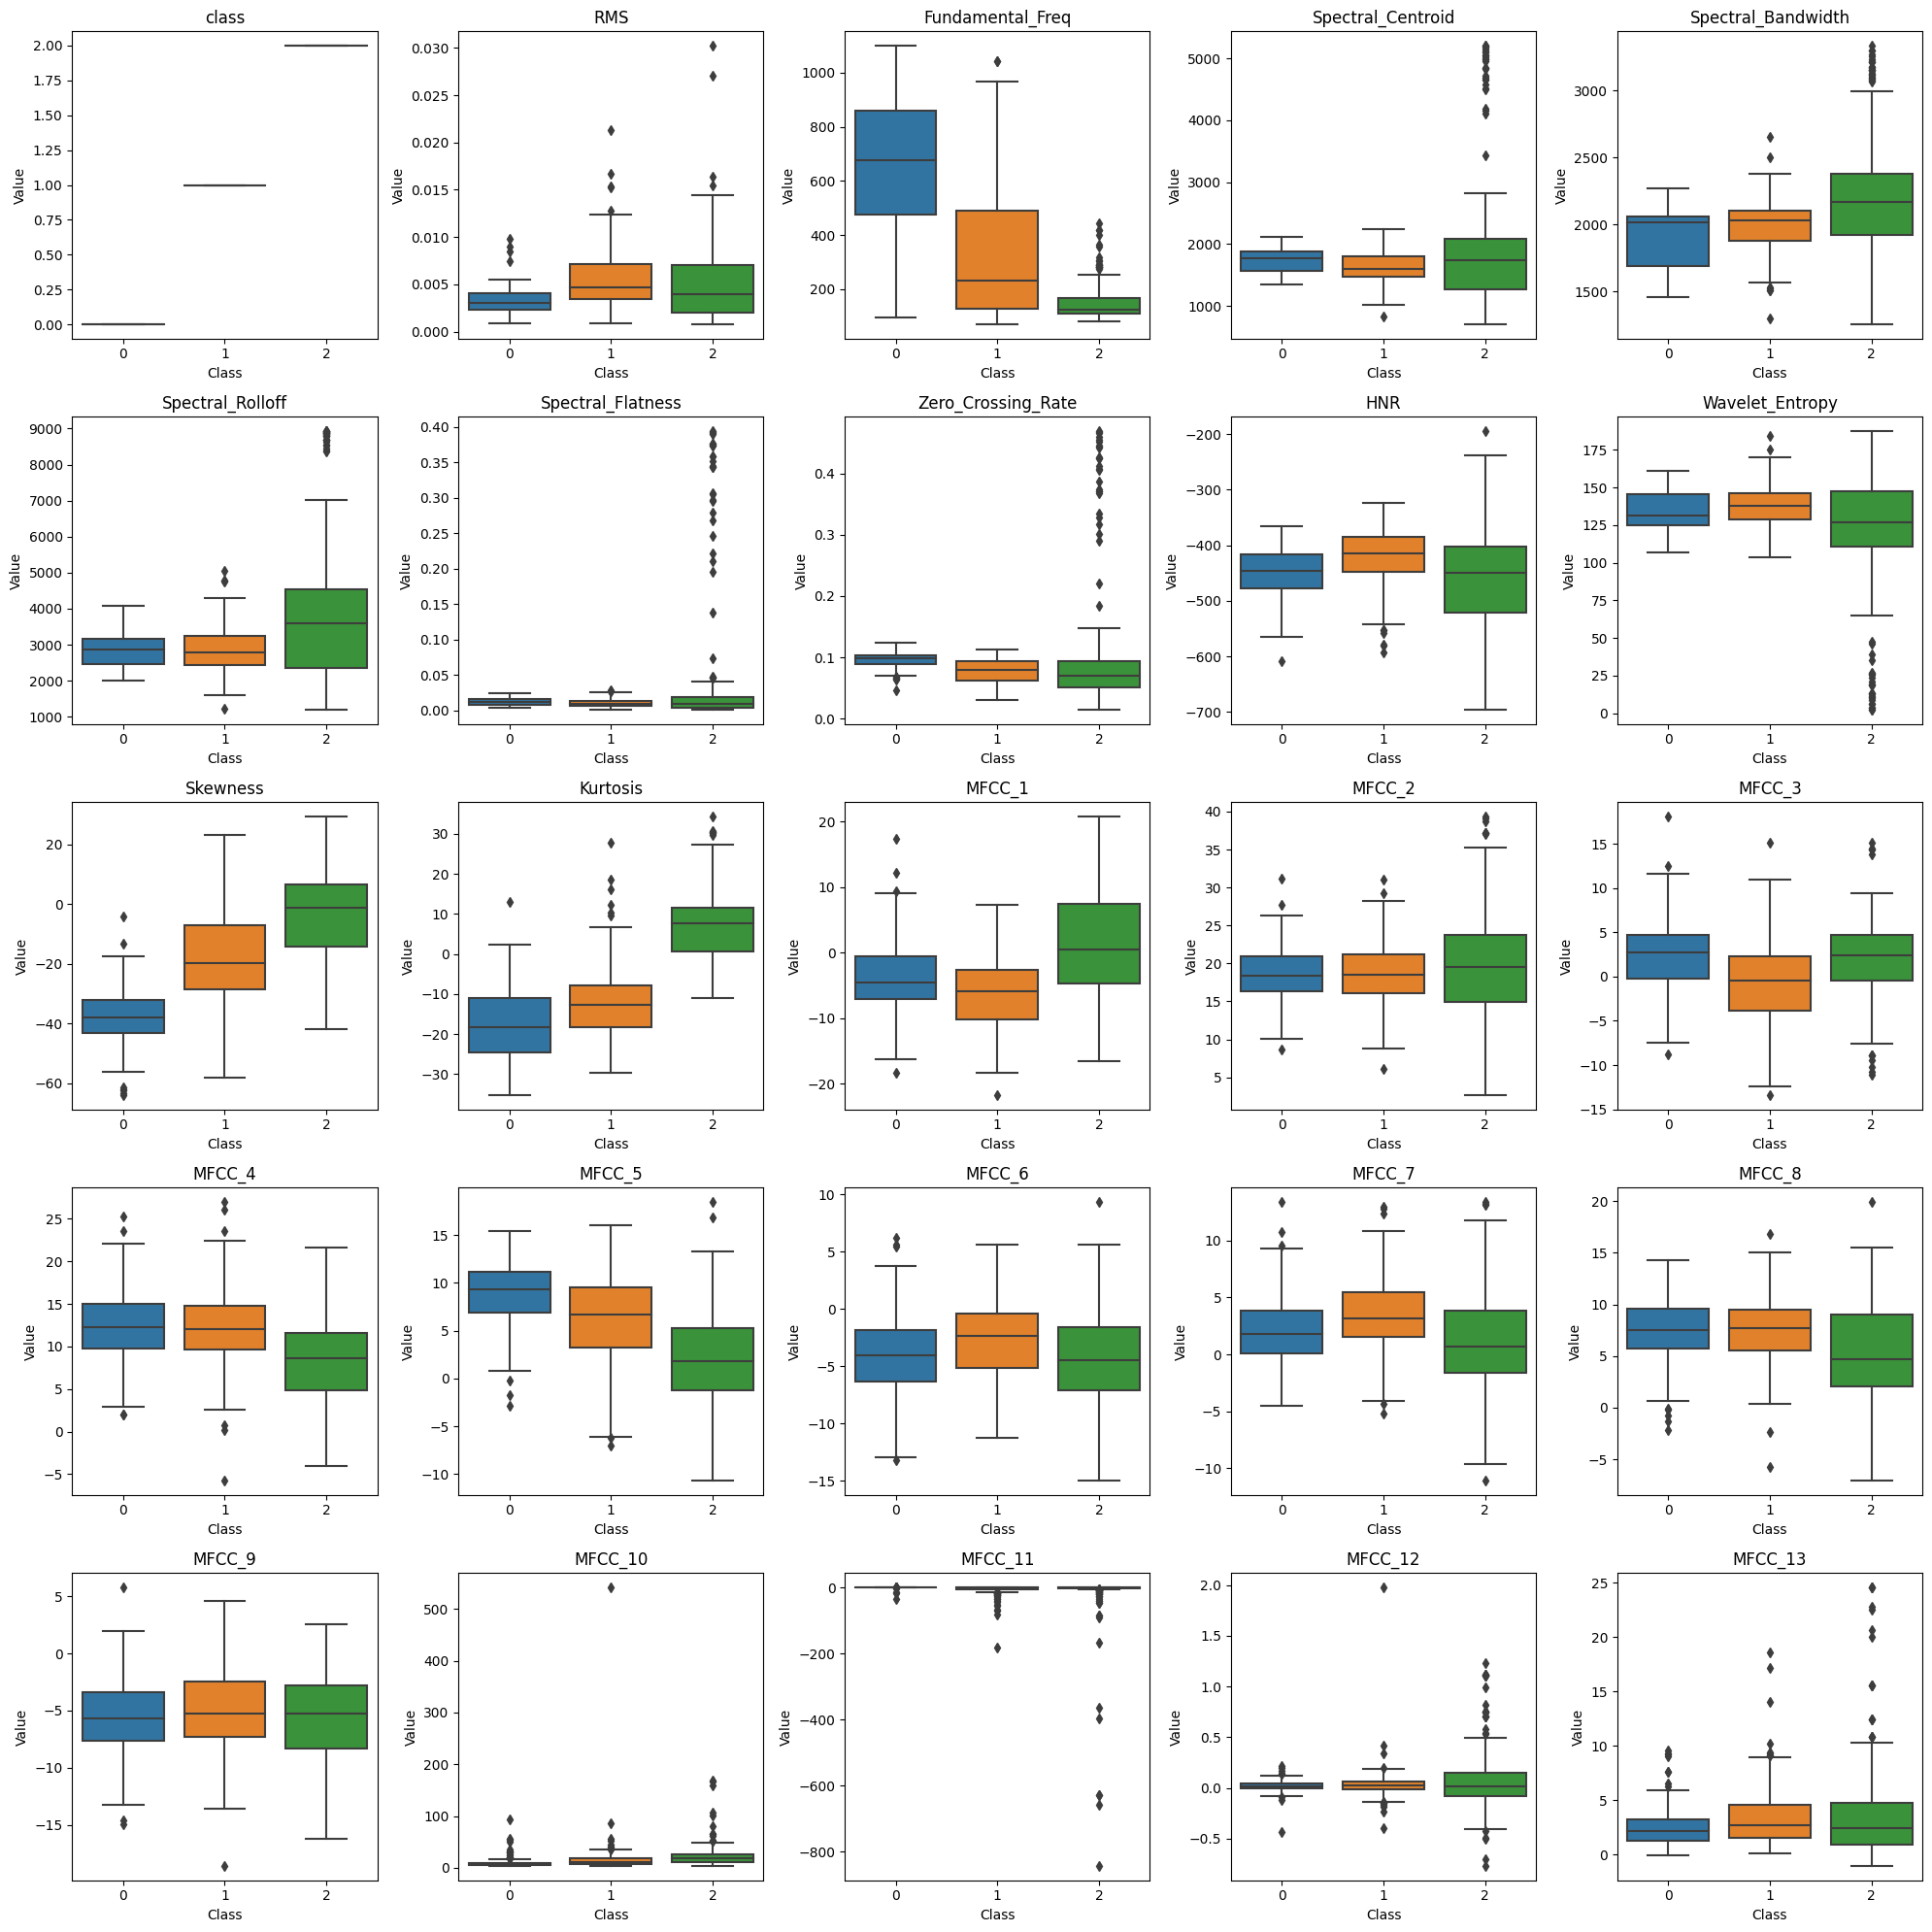

In [15]:
# List of feature columns that you want to visualize
feature_columns = df3.columns
class_column = 'class'

# Number of subplots needed
num_features = len(feature_columns)
num_cols = 5  # Define the number of columns in the subplot grid
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)  # Calculate rows dynamically

# Create subplots with larger figsize
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4*num_rows))
axes = axes.flatten()  # Flatten axes array for easier iteration

# Plot each feature in a separate subplot, separated by class using 'hue'
for idx, feature in enumerate(feature_columns):
    sns.boxplot(ax=axes[idx], x=df3[class_column], y=df3[feature])
    axes[idx].set_title(feature, fontsize=12)
    axes[idx].set_xlabel("Class", fontsize=10)
    axes[idx].set_ylabel("Value", fontsize=10)

# Adjust layout and make sure everything fits
plt.tight_layout()
plt.show()

In [16]:
# Split the Data
X = df3.drop(['class'], axis=1)
Y = df3['class']
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=SEED, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=SEED, stratify=Y_temp)

In [17]:
# Scale the data
scaler = StandardScaler()

# Fit the scaler to X_train and transform all splits
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrames, preserving the column names
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [18]:
# Model Training, Validation, and Testing
def evaluate_model(model, param_grid, model_name):
    print(f"\n{model_name} - Base Model")

    # Perform RFECV for feature selection on training data
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy', min_features_to_select=4)
    rfecv.fit(X_train, Y_train)

    # Get the optimal number of features and the mask
    print(f"Optimal number of features: {rfecv.n_features_}")
    print(f"Selected features: {rfecv.support_}")
    
    X_train_selected = rfecv.transform(X_train)
    X_val_selected = rfecv.transform(X_val)
    X_test_selected = rfecv.transform(X_test)

    # Fit the model on the selected features
    model.fit(X_train_selected, Y_train)
    print(f"Current Parameters: {model.get_params()}")

    # Predictions on the validation set after RFECV feature selection
    Y_val_pred = model.predict(X_val_selected)
    print("Base Model Validation Classification Report (RFECV-selected features):")
    print(classification_report(Y_val, Y_val_pred))

    print("Base Model Validation Confusion Matrix (RFECV-selected features):")
    conf_matrix_base = confusion_matrix(Y_val, Y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_base)
    disp.plot()
    plt.show()

    # Predictions on the test set for the base model after RFECV
    Y_test_pred_base_rfecv = model.predict(X_test_selected)
    print("Base Model Test Classification Report (RFECV-selected features):")
    print(classification_report(Y_test, Y_test_pred_base_rfecv))

    print("Base Model Test Confusion Matrix (RFECV-selected features):")
    conf_matrix_base_rfecv = confusion_matrix(Y_test, Y_test_pred_base_rfecv)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_base_rfecv)
    disp.plot()
    plt.show()

    print(f"\n{model_name} - Hyperparameter Tuning with RFECV-selected Features")
    grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=0)
    grid.fit(X_train_selected, Y_train)
    best_model = grid.best_estimator_
    print(f"Best Parameters: {grid.best_params_}")
    
    # Predictions on the validation set for the tuned model
    Y_val_pred_tuned = best_model.predict(X_val_selected)
    print("Tuned Model Validation Classification Report:")
    print(classification_report(Y_val, Y_val_pred_tuned))

    print("Tuned Model Validation Confusion Matrix:")
    conf_matrix_tuned = confusion_matrix(Y_val, Y_val_pred_tuned)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_tuned)
    disp.plot()
    plt.show()

    # Finally, evaluate on the test set for the tuned model
    print(f"\n{model_name} - Test Set Evaluation")
    Y_test_pred_tuned = best_model.predict(X_test_selected)
    print("Tuned Model Test Classification Report:")
    print(classification_report(Y_test, Y_test_pred_tuned))

    print("Tuned Model Test Confusion Matrix:")
    conf_matrix_test = confusion_matrix(Y_test, Y_test_pred_tuned)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test)
    disp.plot()
    plt.show()


Logistic Regression - Base Model
Optimal number of features: 22
Selected features: [ True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True]
Current Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Base Model Validation Classification Report (RFECV-selected features):
              precision    recall  f1-score   support

           0       0.71      0.85      0.77        20
           1       0.79      0.52      0.63        21
           2       0.88      1.00      0.93        21

    accuracy                           0.79        62
   macro avg       0.79      0.79      0.78        62
weighted avg       0.79      0.79      0.78        62

Base Model Validation 

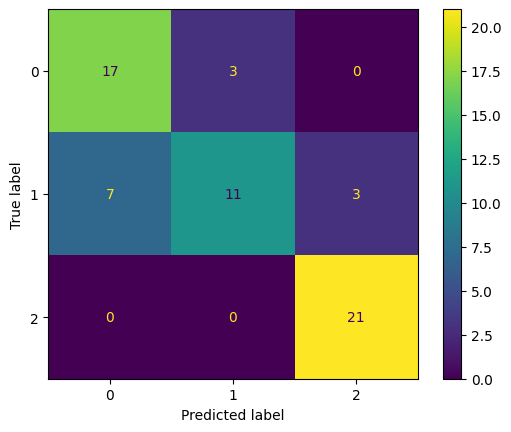

Base Model Test Classification Report (RFECV-selected features):
              precision    recall  f1-score   support

           0       0.74      0.81      0.77        21
           1       0.75      0.71      0.73        21
           2       0.95      0.90      0.93        21

    accuracy                           0.81        63
   macro avg       0.81      0.81      0.81        63
weighted avg       0.81      0.81      0.81        63

Base Model Test Confusion Matrix (RFECV-selected features):


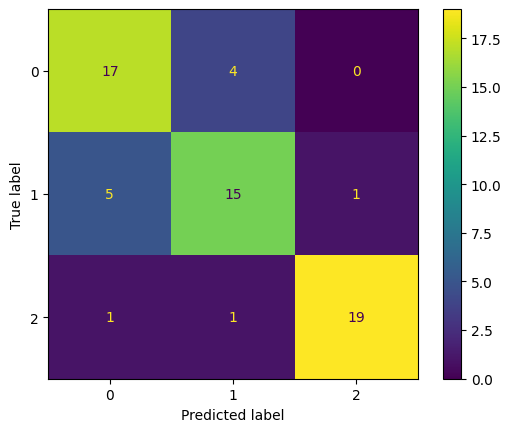


Logistic Regression - Hyperparameter Tuning with RFECV-selected Features
Best Parameters: {'C': 100, 'fit_intercept': True, 'max_iter': 100, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.0001}
Tuned Model Validation Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79        20
           1       0.80      0.57      0.67        21
           2       0.88      1.00      0.93        21

    accuracy                           0.81        62
   macro avg       0.80      0.81      0.80        62
weighted avg       0.81      0.81      0.80        62

Tuned Model Validation Confusion Matrix:


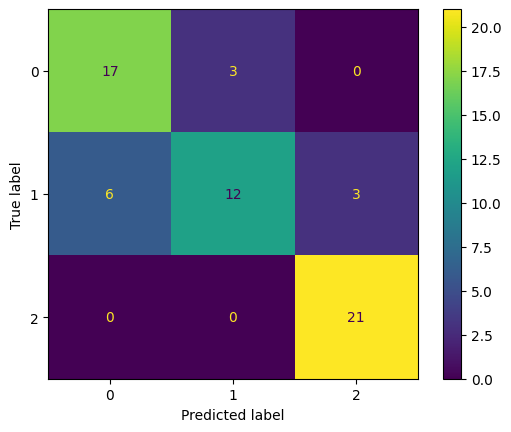


Logistic Regression - Test Set Evaluation
Tuned Model Test Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        21
           1       0.82      0.67      0.74        21
           2       0.95      1.00      0.98        21

    accuracy                           0.84        63
   macro avg       0.84      0.84      0.84        63
weighted avg       0.84      0.84      0.84        63

Tuned Model Test Confusion Matrix:


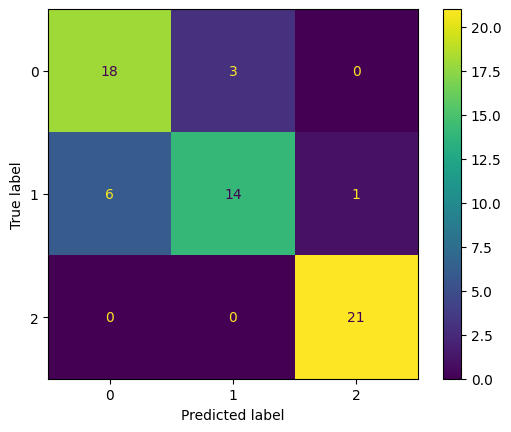

In [19]:
# Logistic Regression
logreg_params = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet', None],  # Regularization type
    'solver': ['lbfgs', 'liblinear', 'saga', 'newton-cg'],  # Optimization algorithm
    'max_iter': [100, 500, 1000],  # Number of iterations for solver to converge
    'tol': [1e-4, 1e-3],  # Tolerance for stopping criteria
    'fit_intercept': [True, False],  # Whether to calculate the intercept for this model
    'multi_class': ['auto', 'ovr', 'multinomial']  # Multiclass strategy
}
logreg = LogisticRegression(random_state=SEED)
evaluate_model(logreg, logreg_params, "Logistic Regression")


SVM - Base Model
Optimal number of features: 22
Selected features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True False  True]
Current Parameters: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Base Model Validation Classification Report (RFECV-selected features):
              precision    recall  f1-score   support

           0       0.71      0.85      0.77        20
           1       0.80      0.57      0.67        21
           2       0.91      1.00      0.95        21

    accuracy                           0.81        62
   macro avg       0.81      0.81      0.80        62
weighted avg       0.81      0.81      0.80        62

Base Model Validation Confusion 

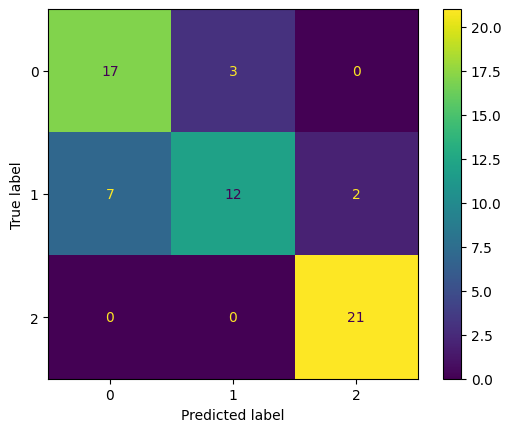

Base Model Test Classification Report (RFECV-selected features):
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        21
           1       0.78      0.67      0.72        21
           2       0.95      0.95      0.95        21

    accuracy                           0.83        63
   macro avg       0.83      0.83      0.82        63
weighted avg       0.83      0.83      0.82        63

Base Model Test Confusion Matrix (RFECV-selected features):


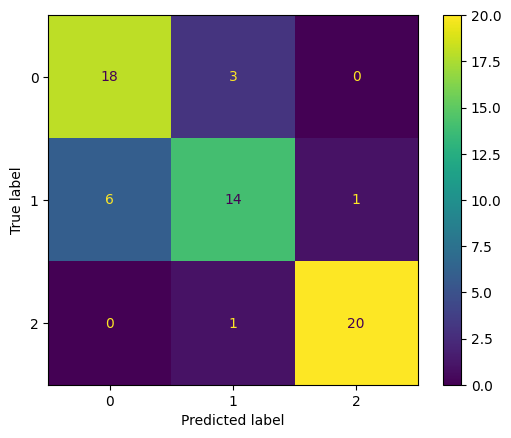


SVM - Hyperparameter Tuning with RFECV-selected Features
Best Parameters: {'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 'scale', 'tol': 0.0001}
Tuned Model Validation Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79        20
           1       0.80      0.57      0.67        21
           2       0.88      1.00      0.93        21

    accuracy                           0.81        62
   macro avg       0.80      0.81      0.80        62
weighted avg       0.81      0.81      0.80        62

Tuned Model Validation Confusion Matrix:


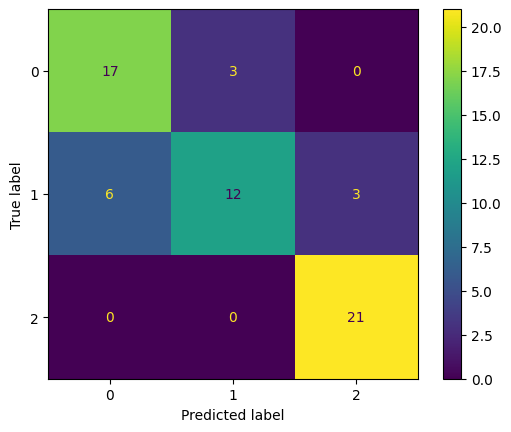


SVM - Test Set Evaluation
Tuned Model Test Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        21
           1       0.84      0.76      0.80        21
           2       0.95      0.90      0.93        21

    accuracy                           0.84        63
   macro avg       0.85      0.84      0.84        63
weighted avg       0.85      0.84      0.84        63

Tuned Model Test Confusion Matrix:


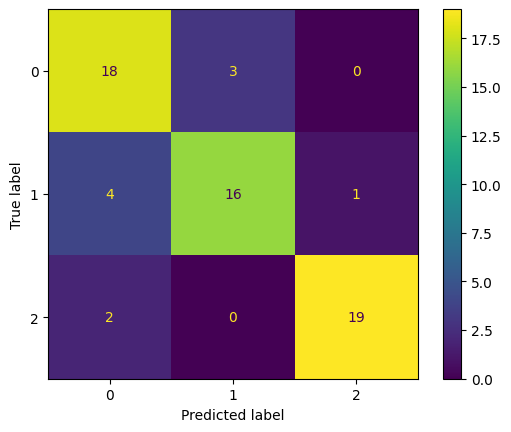

In [20]:
# Support Vector Machine
svm_params = {
    'C': [0.01, 0.1, 1, 10, 100],  # Expanded range for regularization strength
    'gamma': ['scale', 'auto', 0.001, 0.01],  # Added specific values for more granularity
    'degree': [2, 3, 4],  # Expanded degree options for polynomial kernel
    'coef0': [0, 0.5, 1],  # Expanded range for 'poly' and 'sigmoid' use cases
    'tol': [1e-4, 1e-3, 1e-2],  # Added more tolerance values for convergence control
}
svm = SVC(random_state=SEED, kernel='linear')
evaluate_model(svm, svm_params, "SVM")


Decision Tree - Base Model
Optimal number of features: 7
Selected features: [ True False False False False False False False  True  True  True  True
 False False False False False False False False False  True False  True]
Current Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
Base Model Validation Classification Report (RFECV-selected features):
              precision    recall  f1-score   support

           0       0.70      0.80      0.74        20
           1       0.72      0.62      0.67        21
           2       0.95      0.95      0.95        21

    accuracy                           0.79        62
   macro avg       0.79      0.79      0.79        62
weighted avg       0.79      0.79      0.79        62

Base Model Validation Confu

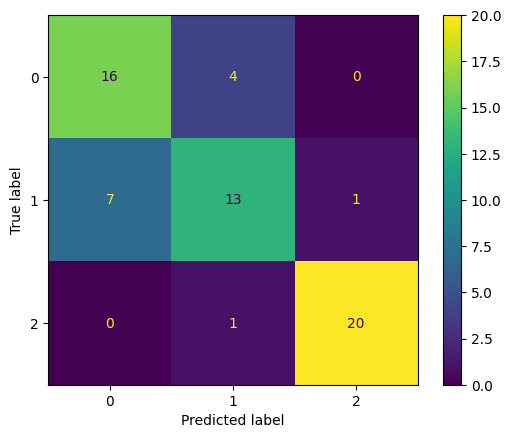

Base Model Test Classification Report (RFECV-selected features):
              precision    recall  f1-score   support

           0       0.70      0.76      0.73        21
           1       0.68      0.62      0.65        21
           2       0.90      0.90      0.90        21

    accuracy                           0.76        63
   macro avg       0.76      0.76      0.76        63
weighted avg       0.76      0.76      0.76        63

Base Model Test Confusion Matrix (RFECV-selected features):


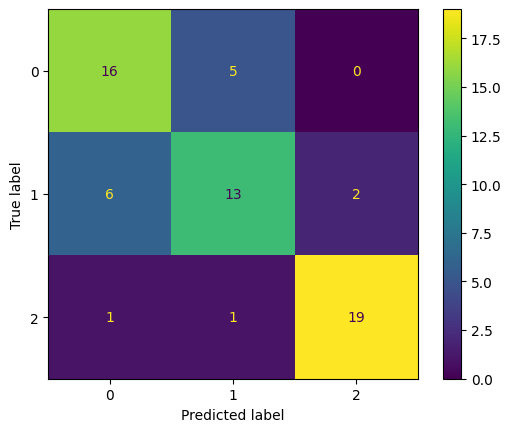


Decision Tree - Hyperparameter Tuning with RFECV-selected Features
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Tuned Model Validation Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.80      0.74        20
           1       0.71      0.57      0.63        21
           2       0.91      0.95      0.93        21

    accuracy                           0.77        62
   macro avg       0.77      0.77      0.77        62
weighted avg       0.77      0.77      0.77        62

Tuned Model Validation Confusion Matrix:


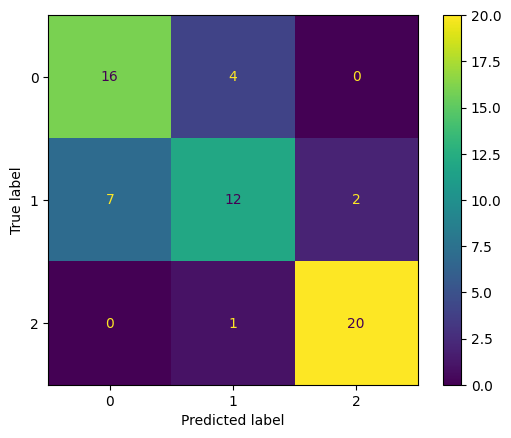


Decision Tree - Test Set Evaluation
Tuned Model Test Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.81      0.77        21
           1       0.71      0.57      0.63        21
           2       0.87      0.95      0.91        21

    accuracy                           0.78        63
   macro avg       0.77      0.78      0.77        63
weighted avg       0.77      0.78      0.77        63

Tuned Model Test Confusion Matrix:


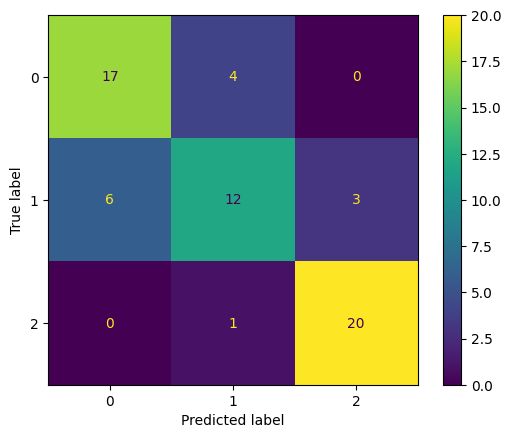

In [21]:
# Decision Tree Classifier
dtc_params = {
    'max_depth': [None, 10, 20],  # Keep default (None) and reduce depth options
    'min_samples_split': [2, 5],  # Keep the default (2) and reduce other options
    'min_samples_leaf': [1, 2],  # Keep the default (1) and reduce options
    'max_features': [None, 'auto'],  # Keep default (None) and reduce options
    'splitter': ['best'],  # Keep default (best) and remove 'random'
    'criterion': ['gini'],  # Keep default ('gini') and remove 'entropy'
    'max_leaf_nodes': [None, 10],  # Keep default (None) and reduce options
    'min_impurity_decrease': [0.0, 0.01],  # Keep default (0.0) and reduce options
}
dtc = DecisionTreeClassifier(random_state=SEED)
evaluate_model(dtc, dtc_params, "Decision Tree")


Random Forest - Base Model
Optimal number of features: 21
Selected features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True False  True  True False  True]
Current Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Base Model Validation Classification Report (RFECV-selected features):
              precision    recall  f1-score   support

           0       0.70      0.80      0.74        20
           1       0.73      0.52      0.61        21
           2       0.88      1.00      0.93        21

    accuracy                           0.77        62
   macro avg       0.

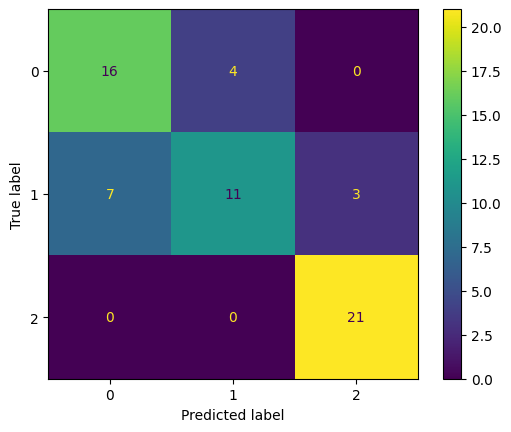

Base Model Test Classification Report (RFECV-selected features):
              precision    recall  f1-score   support

           0       0.75      0.71      0.73        21
           1       0.71      0.71      0.71        21
           2       0.91      0.95      0.93        21

    accuracy                           0.79        63
   macro avg       0.79      0.79      0.79        63
weighted avg       0.79      0.79      0.79        63

Base Model Test Confusion Matrix (RFECV-selected features):


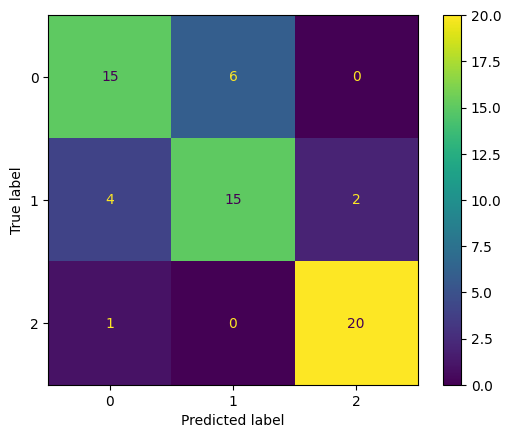


Random Forest - Hyperparameter Tuning with RFECV-selected Features
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Tuned Model Validation Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.80      0.74        20
           1       0.73      0.52      0.61        21
           2       0.88      1.00      0.93        21

    accuracy                           0.77        62
   macro avg       0.77      0.77      0.76        62
weighted avg       0.77      0.77      0.76        62

Tuned Model Validation Confusion Matrix:


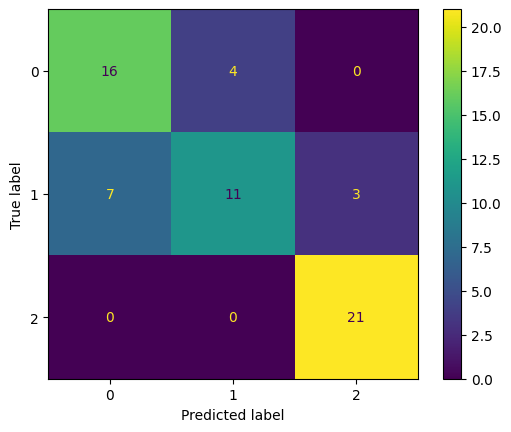


Random Forest - Test Set Evaluation
Tuned Model Test Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.81      0.77        21
           1       0.79      0.71      0.75        21
           2       0.95      0.95      0.95        21

    accuracy                           0.83        63
   macro avg       0.83      0.83      0.83        63
weighted avg       0.83      0.83      0.83        63

Tuned Model Test Confusion Matrix:


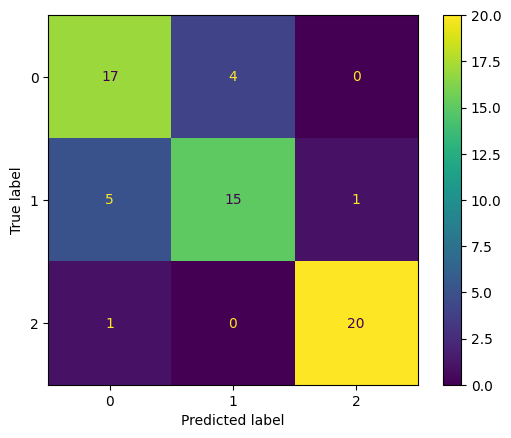

In [22]:
# Random Forest Classifier
rfc_params = {
    'n_estimators': [50, 100, 200],  # Include 100 for default
    'max_depth': [None, 10, 20],  # Include None for default
    'min_samples_split': [2, 5, 10],  # Include 2 for default
    'min_samples_leaf': [1, 2, 4],  # Include 1 for default
    'max_features': ['auto'],  # Include 'auto' for default
    'bootstrap': [True],  # Include True for default
    'criterion': ['gini'],  # Include 'gini' for default
}

rfc = RandomForestClassifier(random_state=SEED)
evaluate_model(rfc, rfc_params, "Random Forest")


XGBoost - Base Model
Optimal number of features: 20
Selected features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True False  True False  True  True  True  True False False  True  True]
Current Parameters: {'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'error', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 

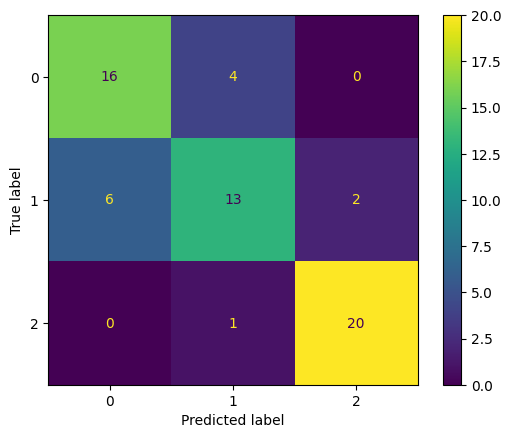

Base Model Test Classification Report (RFECV-selected features):
              precision    recall  f1-score   support

           0       0.74      0.81      0.77        21
           1       0.79      0.71      0.75        21
           2       0.95      0.95      0.95        21

    accuracy                           0.83        63
   macro avg       0.83      0.83      0.83        63
weighted avg       0.83      0.83      0.83        63

Base Model Test Confusion Matrix (RFECV-selected features):


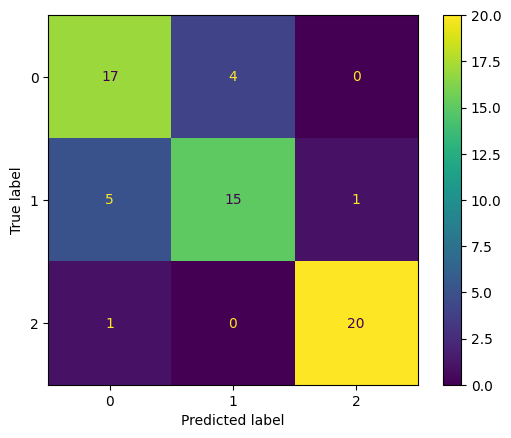


XGBoost - Hyperparameter Tuning with RFECV-selected Features
Best Parameters: {'colsample_bylevel': 0.8, 'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.8}
Tuned Model Validation Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        20
           1       0.72      0.62      0.67        21
           2       0.91      0.95      0.93        21

    accuracy                           0.79        62
   macro avg       0.79      0.79      0.79        62
weighted avg       0.79      0.79      0.79        62

Tuned Model Validation Confusion Matrix:


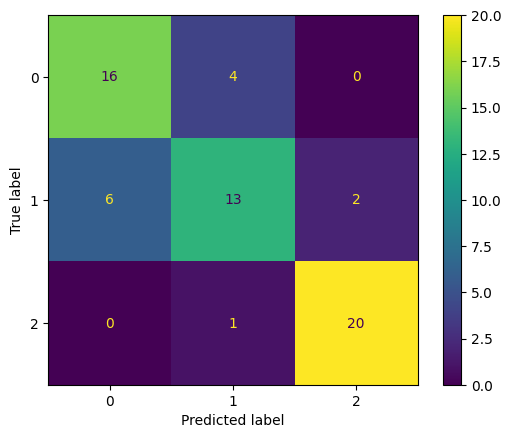


XGBoost - Test Set Evaluation
Tuned Model Test Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        21
           1       0.83      0.71      0.77        21
           2       0.95      0.95      0.95        21

    accuracy                           0.84        63
   macro avg       0.85      0.84      0.84        63
weighted avg       0.85      0.84      0.84        63

Tuned Model Test Confusion Matrix:


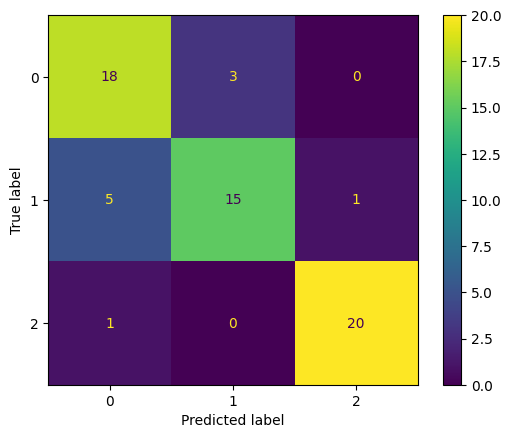

In [23]:
# XGBoost Classifier
xgb_params = {
    'n_estimators': [100, 200],  # Reduced options, focusing on commonly used values
    'max_depth': [3, 6],  # Default depth and one additional option for complexity
    'learning_rate': [0.1, 0.3],  # Default value and a slightly smaller step size
    'subsample': [0.8, 1.0],  # Focused range, including the default
    'colsample_bytree': [0.8, 1.0],  # Commonly used fractions, including the default
    'colsample_bylevel': [0.8],  # Default fraction only
    'gamma': [0, 0.1],  # Default value and a small positive value for experimentation
    'reg_alpha': [0, 1],  # Default L1 regularization and one additional value
    'reg_lambda': [1, 10],  # Default L2 regularization and a higher option for control
    'scale_pos_weight': [1]  # Default for balanced classes
}
xgb = XGBClassifier(random_state=SEED, use_label_encoder=False, eval_metric='error')
evaluate_model(xgb, xgb_params, "XGBoost")